To Do:

    - choose interpolation between allocal_factors
    - in particular: how do we interpolate if souce extends over many slices?
    - if required which parameter should be kept fixed?
    - optimize runtime

In [35]:
# header

import os.path
import numpy as np
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table, vstack
from mpdaf.drs import PixTable
from tqdm import tqdm
import warnings
from scipy.stats import binned_statistic_2d
from scipy import ndimage
from astropy import units as u
import copy as cp
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib import colors

# Load Pixtable IFU frames

In [36]:
class Autocal():
    
    def __init__(self, datadir, file_factors, file_mask, nifu=24, nsli=48, nquad=20):
        
        self.nifu = nifu     # number of IFUs
        self.nsli = nsli     # number of slices
        self.nquad = nquad   # number of segments
        
        self.datadir = datadir         # contains of pixtable files
        self.file_factors = file_factors
        self.file_mask = file_mask
        
        self.files = np.sort([file for file in os.listdir(datadir) if 'PIX' in file])
        self.autocal_factors = self.load_autocal_table(file_factors)
        self.mask, self.mask_hdr = self.load_autocal_mask(file_mask)
        
    def load_autocal_table(self, file):
        
        with fits.open(file) as hdul: 
            factors = Table(hdul[1].data)
            
        return factors
    
    def load_autocal_mask(self, file):
        
        # two-dimenional image
        
        with fits.open(file) as hdul: 
            autocal_mask = hdul[0].data.astype(bool)
            hdr = hdul[0].header
            
        return autocal_mask, hdr

In [127]:
class Allocal(Autocal):
    
    def __init__(self, autocal, mult=1):
            
        self.nifu = autocal.nifu
        self.nsli = autocal.nsli
        self.nquad = autocal.nquad
        self.segments = self.setup_segments()
        
    def setup_segments(self):
        
        # creates attribute 'segments' that is a dictionary of 
        # wavelength-intervals. The ranges were hardcoded and were 
        # chosen to end in between groups of sky-lines to minimize 
        # the influence of the sampling c.f. Weilbacher+20, 2020A&A...641A..28W
        
        slices = np.arange(self.nsli)+1
        quads = np.arange(self.nquad)+1
        
        limits = [0, 5000, 5265, 5466, 5658, 5850, 6120, 6440, 6678, 6931, 7211,
                  7450, 7668, 7900, 8120, 8330, 8565, 8731, 9012, 9275, 10000]

        segments = Table([quads, limits[:-1], limits[1:]],
                          names=('nr', 'wave_min', 'wave_max'),
                          meta={'name': 'Segments'}
                        )
        
        return segments  
    
    def goodpixels(self, pxtbl):
        
        # uses autocal_mask image to generate 
        # table that contains good pixels (i.e. do not belong to source)

        xpos = pxtbl.get_xpos()
        ypos = pxtbl.get_ypos()

        # approximate (xpos,ypos) by rounding to autocal_mask grid image coordinates
        x_px = (xpos-autocal.mask_hdr['CRVAL1']).astype(int)
        y_px = (ypos-autocal.mask_hdr['CRVAL2']).astype(int)

        return autocal.mask[y_px,x_px]
    
    
    def statistic(self, array):
        
        # statistic applied to pixels with coordinates (ifu,sli,quad) 
        
        if len(array)!=0: 
            return np.nanmedian(array)
        else:
            return np.nan
        

    def row(self,idx,sdx,qdx):
        
        # returns the row index within the AUTOCAL_FACTORS table
        # input values are array positions
        # i.e. positions start at 0
        
        return qdx*(self.nsli*self.nifu) + idx*(self.nsli) + sdx
                
        
    def run(self, outdir, outfile='allocal_factors.fits', write=True):
        
        # this function generates a table that contains factors
        # computed from each (ifu,slice,quad) region in the data cube
        # the format and order matches 'AUTOCAL_FACTORS.fits'
        # which is generated by the MUSE pipeline

        # (1) setup table with 'AUTOCAL_FACTORS.fits' format
        tbl_ref = autocal.autocal_factors
        myfactors =  Table([np.full(len(tbl_ref),np.nan)]*5,names=('ifu', 'sli', 'quad', 'npts', 'corr'))

        # (2) compute my autocal factors
        # perform a statistic for each wavelength inteval
        # append subtables to final table
        
        for idx in tqdm(range(self.nifu)):
            ifu = idx+1
            
            # (0) load pixtable
            substr = '-'+str(ifu).zfill(2)
            file = [string for string in autocal.files if substr in string][0]
            pxtbl = PixTable(datadir+file, wcs=u.pix)
            
            # (1) get pixtable and detector coordinates 
            lbda = pxtbl.get_lambda()
            data = pxtbl.get_data()
            origin = pxtbl.get_origin()
            ifus = pxtbl.origin2ifu(origin)
            slcs = pxtbl.origin2slice(origin)
                
            isifu = (ifus==ifu)
            goodpixels = self.goodpixels(pxtbl)
                
            for sdx in (np.arange(self.nsli)):
                sli = sdx+1
                issli = (slcs==sli)

                for qdx in np.arange(self.nquad)[:1]:
                    quad = qdx+1
                    isquad = (  (lbda > (self.segments[qdx])['wave_min']) 
                              & (lbda <= (self.segments[qdx])['wave_max']))
                    
                    select = isifu & issli & isquad & goodpixels
                    
                    pos = self.row(idx,sdx,qdx)
                    myfactors['ifu'][pos] = ifu
                    myfactors['sli'][pos] = sli
                    myfactors['quad'][pos] = quad
                    myfactors['npts'][pos] = np.sum(select)
                    myfactors['corr'][pos] = self.statistic(data[select])
                    #myfactors['corr_orig'][idx] = np.nan
            
            pxtbl.hdulist.close()
        
        # normalize to average in (*,*,quad)
        self.allocal_factors = self.nrmlze(self.intrplt(myfactors))
        
        if write==True: self.write()
        
        return None
    
    

    def rplc_nans(self,A):

        # replaces the NANs of an array with interpolated values

        select = ~np.isnan(A)
        xp = select.ravel().nonzero()[0]
        fp = A[~np.isnan(A)]
        x  = np.isnan(A).ravel().nonzero()[0]

        try: A[np.isnan(A)] = np.interp(x, xp, fp)
        except: None

        return A

    def intrplt(self, allocal_factors):

        # interpolate allocal_factors table for slices without value

        for qdx in np.arange(self.nquad):
            quad = qdx+1
            isquad = (allocal_factors['quad'] == quad)

            for idx in range(self.nifu):
                ifu = idx+1
                isifu = (allocal_factors['ifu'] == ifu)

                select = isifu & isquad

                allocal_factors['corr'][select] = self.rplc_nans(allocal_factors['corr'][select])

        return allocal_factors

    def nrmlze(self, allocal_factors):

        # normalize the table to the mean flux measued within
        # the segments. this is the step where the  interpolation
        # between the ifu/slices should be implemented

        for qdx in np.arange(self.nquad):
            quad = qdx+1
            isquad = (allocal_factors['quad'] == quad)
            allocal_factors['corr'][isquad] /= np.nanmedian(allocal_factors['corr'][isquad])

        allocal_factors['corr'] = 1/allocal_factors['corr']

        return allocal_factors

    
    def write(self,outfile='allocal_factors.fits'):
            
        # writes allocal_factors after run() was executed
        
        hdul = fits.open(autocal.file_factors)
        hdul[1].data = fits.BinTableHDU(self.allocal_factors).data
        hdul.writeto(outdir+outfile, overwrite=True)
            
        return None

In [128]:
class Calibration(Allocal):
    
    def __init__(self, allocal, file_factors, mult=1):
            
        self.nifu = allocal.nifu
        self.nsli = allocal.nsli
        self.nquad = allocal.nquad
        self.allocal_factors = self.load_autocal_table(file_factors)
        
    def load_autocal_table(self, file):
        
        with fits.open(file) as hdul: 
            factors = Table(hdul[1].data)
            
        return factors
    
    def run(self, outdir, write=True):
        
        pxtbls_corr = type('', (), {})()     
        for idx in tqdm(range(allocal.nifu)):
            ifu = idx+1
            
            # (0) load original pixtable
            substr = '-'+str(ifu).zfill(2)
            file = [string for string in autocal.files if substr in string][0]
            pxtbl = PixTable(datadir+file, wcs=u.pix)
            
            # (1) setup new pixtable
            pxtbl_corr = cp.copy(pxtbl)
            lbda = pxtbl.get_lambda()
            data = pxtbl.get_data()
            data_corr = cp.copy(data)
            origin = pxtbl.get_origin()
            ifus = pxtbl.origin2ifu(origin)
            slcs = pxtbl.origin2slice(origin)

            goodpixels = allocal.goodpixels(pxtbl)
            
            # (2) correction
            for sdx in np.arange(self.nsli):
                sli = sdx+1

                for qdx,quad in enumerate(allocal.segments[:1]):

                    isquad = (lbda>quad['wave_min']) & (lbda<=quad['wave_max'])
                    issli = (slcs==sli)
                    select = issli & isquad
                    
                    row = self.row(idx,sdx,qdx)
                    data_corr[select] = data[select]*self.allocal_factors[row]['corr']

            pxtbl_corr.data = data_corr
            setattr(pxtbls_corr, 'ifu_'+str(idx).zfill(2), pxtbl_corr)
            
            if write==True:  pxtbl_corr.write(outdir+file)
            
            pxtbl.hdulist.close()
            
        self.pxtbls_corr = pxtbls_corr
        
        return None

### Compute allocal factors

In [129]:
file_factors= 'Data/PHL909/muse_scipost_1/products_dir/AUTOCAL_FACTORS_0001.fits'
file_mask = 'Data/PHL909/muse_scipost_1/products_dir/AUTOCAL_MASK_0001.fits'
datadir = 'Data/PHL909/muse_scibasic_4/products_dir/'
outdir = 'Data/PHL909/flatfield/'

In [130]:
# (0) load data 
autocal = Autocal(datadir, file_factors, file_mask, nifu=24, nsli=48, nquad=20)

# (1) initialize class to compute my factors
allocal = Allocal(autocal)

In [131]:
# (2) compute my factors
allocal.run(outdir)

100%|███████████████████████████████████████████| 24/24 [01:15<00:00,  3.15s/it]
/home/winkel/software/miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_12480/1117906651.py:121: ResourceWarning: unclosed file <_io.BufferedReader name='Data/PHL909/muse_scipost_1/products_dir/AUTOCAL_FACTORS_0001.fits'>
  if write==True: self.write()


In [ ]:
# (4) flat field correction with my factors
calibration = Calibration(allocal, outdir+'allocal_factors.fits')
calibration.run(outdir, write=True)

 75%|████████████████████████████████▎          | 18/24 [01:00<00:20,  3.49s/it]

### Plot Result

In [ ]:
class Plot(Allocal):
    def __init__(self, allocal, datadir, datadir_corr):
        
        self.datadir =  datadir
        self.outdir =  outdir
        
        #self.pixtables = self.load_pixtables(datadir)
        #self.pixtables_corr = self.load_pixtables(datadir_corr)
        
        
    def load_pixtables(self, datadir):
        
        # load each pixtable listed in 'files'
        # return attributes
        
        files = np.sort([datadir+file for file in os.listdir(datadir) if 'PIX' in file])
        pixtables = type('', (), {})() 
    
        for idx,file in enumerate(files):
            pxtbl = PixTable(file,wcs=u.pix)
            setattr(pixtables, 'ifu_'+str(idx).zfill(2), pxtbl)
            
        return pixtables
    
    def setup_plot_param(self):
        
        mult = 1
        matplotlib.rcParams.update({'font.size': 15*mult})
        matplotlib.rcParams['legend.fontsize'] = 15*mult
        matplotlib.rcParams['axes.linewidth'] = 1
        matplotlib.rcParams['xtick.labelsize'] = 15*mult
        matplotlib.rcParams['ytick.labelsize'] = 15*mult
        matplotlib.rcParams['xtick.major.size'] = 5
        matplotlib.rcParams['ytick.major.size'] = 5
        matplotlib.rcParams['xtick.major.width'] = 1
        matplotlib.rcParams['ytick.major.width'] = 1
        matplotlib.rcParams['xtick.minor.size'] = 3
        matplotlib.rcParams['ytick.minor.size'] = 3
        matplotlib.rcParams['xtick.minor.width'] = 1
        matplotlib.rcParams['ytick.minor.width'] = 1
        matplotlib.rcParams['xtick.direction'] = 'in'
        matplotlib.rcParams['ytick.direction'] = 'in'
        matplotlib.rcParams['xtick.bottom'] = True
        matplotlib.rcParams['xtick.top'] = True
        matplotlib.rcParams['ytick.left'] = True
        matplotlib.rcParams['ytick.right'] = True
        matplotlib.rcParams['axes.labelsize'] = 15*mult
        matplotlib.rcParams['text.usetex'] = True
        
    def colorbar(self, mappable,orientation="vertical",ticks=None,label=None, fontsize=14,format=None):
    
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        if orientation=='vertical':
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.tick_params(length=5,width=1,labelsize=.8*fontsize)
            
            cb=fig.colorbar(mappable, cax=cax,orientation=orientation,format=format)
            cb.set_label(label, labelpad=5, fontsize=fontsize)
            
        elif orientation=='horizontal':
            cax = divider.append_axes("top", size="5%", pad=0.05)
        
            cb=fig.colorbar(mappable, cax=cax,orientation=orientation,format=format)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            cax.tick_params(bottom=False, top=True, length=5,width=1)
            cb.set_label(label, labelpad=-45, fontsize=fontsize)
            
        return cb
    
    def tbl_to_img(self,x,y,data):
            
        # this function transforms a single PIXTABLE into an image
        # for a given segment, determine a statistic for
        # projected PIXTABLE values on MUSE grid and compute statistic 

        xbin = np.arange(x.min(),x.max(),1)
        ybin = np.arange(y.min(),y.max(),1)

        binned = binned_statistic_2d(x, y, data, bins=[xbin,ybin], statistic='median')

        # extent: [ymin,ymax,xmin,xmax]
        extent = [int(ybin.min())+160,int(ybin.min())+160+binned.statistic.shape[1],
                  int(xbin.min())+160,int(xbin.min())+160+binned.statistic.shape[0]]

        return binned.statistic, extent
    
    
    
    def img_quad(self,datadir,quad, mask=False):
        
        # For a given set of pixtables this function integrates the flux within a the segment <quad>,
        # generates the 2D images and places them in a pre-defined grid that samatplotlibes the FOV
        
        img = np.full([320,320],np.nan)
        msk = np.full([320,320],np.nan)
        
        for idx in range(allocal.nifu):
            ifu = idx+1
            substr = '-'+str(ifu).zfill(2)
            file = [string for string in autocal.files if substr in string][0]
            pxtbl = PixTable(datadir+file, wcs=u.pix)
            
            isquad = (  (pxtbl.get_lambda() > (allocal.segments[quad])['wave_min']) 
                      & (pxtbl.get_lambda() < (allocal.segments[quad])['wave_max'])
                     )

            x = pxtbl.get_xpos()[isquad]
            y =  pxtbl.get_ypos()[isquad]
            data = pxtbl.get_data()[isquad]
            mask = allocal.goodpixels(pxtbl)[isquad]
                
            ifuimg, extent = self.tbl_to_img(x,y,data)   
            ifumsk,_ = self.tbl_to_img(x,y,mask)
            
            img[extent[2]:extent[3],extent[0]:extent[1]] = ifuimg
            msk[extent[2]:extent[3],extent[0]:extent[1]] = ifumsk
                        
            pxtbl.hdulist.close()
            
        return img,msk
    
    
    def spectrum(self,datadir, ifu,sli):
    
        # this function generates a 1D spectrum from the integrated
        # flux within a given ifu and sli
        
        # get data
        substr = '-'+str(ifu).zfill(2)
        file = [string for string in autocal.files if substr in string][0]
        pxtbl = PixTable(datadir+file, wcs=u.pix)
        lbda = pxtbl.get_lambda()
        data = pxtbl.get_data()
        ifus = pxtbl.origin2ifu(pxtbl.get_origin())
        slcs = pxtbl.origin2slice(pxtbl.get_origin())
        
        # select pixels that belong to ifu and sli
        select = (slcs == sli) & (ifus==ifu)
        
        # bin data to MUSE wavelength grid
        bins = np.arange(4750,9300,1.25)
        spec, wave, binnum = stats.binned_statistic(x=lbda[select],values=data[select],
                                            statistic='median', bins=bins)
        pxtbl.hdulist.close()
            
        return ndimage.median_filter(spec,size=20), wave[:-1]
    
    def coordinates(self,ifu,sli,quad):
        
        # get data
        substr = '-'+str(ifu).zfill(2)
        file = [string for string in autocal.files if substr in string][0]
        pxtbl = PixTable(datadir+file, wcs=u.pix)
        lbda = pxtbl.get_lambda()
        data = pxtbl.get_data()
        ifus = pxtbl.origin2ifu(pxtbl.get_origin())
        slcs = pxtbl.origin2slice(pxtbl.get_origin())
        
        # select pixels that belong to ifu and sli
        issli = (slcs == sli)
        isquad = (  (pxtbl.get_lambda() > (allocal.segments[quad])['wave_min']) 
                      & (pxtbl.get_lambda() < (allocal.segments[quad])['wave_max'])
                     )
        select = issli&isquad
        
        return pxtbl.get_ypos()[select]+160, pxtbl.get_xpos()[select]+160
        
    def plot_all(self,ifu,sli,quad):
        
        fig = plt.figure(figsize=(12,8), dpi=150)
        outer = gridspec.GridSpec(2,1, hspace=.2, height_ratios=[1,1.3]) 
        inner1 = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=outer[1])
        inner2 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=outer[0],height_ratios = [1,.3],hspace=0) 
        
        self.plot_maps(ifu,sli,quad, gs=inner1,savefig=False)
        self.plot_spec(ifu,sli, gs=inner2,savefig=False)
        
        return fig
    
    def plot_maps(self,ifu,sli,quad,gs=None,savefig=False):

        img_orig, img_mask = p.img_quad(self.datadir,quad)
        img_corr,_ = p.img_quad(self.outdir,quad)
        ratio = img_orig/img_corr

        if gs==None:                    # setup figure
            fig = plt.figure(figsize=(8,4), dpi=200)
            gs = gridspec.GridSpec(2,1,wspace=None, hspace=0, height_ratios=[1,.3]) 
            
        
        ax0 = plt.subplot(gs[0])        # original
        vmin,vmax = np.nanpercentile(img_orig,[5,95])
        im = ax0.imshow(img_orig, cmap='gnuplot2', origin='lower', vmin=vmin, vmax=vmax)
        self.colorbar(im, orientation='horizontal', fontsize=15)
        ax0.text(.05, .85, 'quad = '+str(quad), fontsize=10, transform = ax0.transAxes, horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=.8, edgecolor='black', linewidth=.5,  boxstyle='round,pad=.3'))
        ax0.text(.95, .85, 'original', fontsize=10, transform = ax0.transAxes, horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=.8, edgecolor='black', linewidth=.5,  boxstyle='round,pad=.3'))
        ax0.set_yticks([])

        ax1 = plt.subplot(gs[1])        # corrected
        im = ax1.imshow(img_corr, cmap='gnuplot2', origin='lower', vmin=vmin, vmax=vmax)
        self.colorbar(im, orientation='horizontal', fontsize=15)
        ax1.text(.95, .85, 'corrected', fontsize=10, transform = ax1.transAxes, horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=.8, edgecolor='black', linewidth=.5,  boxstyle='round,pad=.3'))
        ax1.set_yticks([])

        ax2 = plt.subplot(gs[2])        # ratio
        p5,p50,p95 = np.nanpercentile(ratio,[5,50,95])
        dv = max(np.abs(p5-1),np.abs(p95-1))
        im = ax2.imshow(ratio, cmap='coolwarm', origin='lower', vmin=1-dv, vmax=1+dv)
        self.colorbar(im, orientation='horizontal', fontsize=15)
        ax2.text(.95, .85, 'ratio', fontsize=10, transform = ax2.transAxes, horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=.8, edgecolor='black', linewidth=.5,  boxstyle='round,pad=.3'))
        ax2.set_yticks([])

        ax3 = plt.subplot(gs[3])        # mask
        im = ax3.imshow(img_mask, origin='lower')
        ax3.scatter(*self.coordinates(ifu,sli,quad), s=.5, c='green')
        ax3.text(.95, .85, 'source mask', fontsize=10, transform = ax3.transAxes, horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=.8, edgecolor='black', linewidth=.5,  boxstyle='round,pad=.3'))
        self.colorbar(im, orientation='horizontal', fontsize=15)
        ax3.set_yticks([])
        
        #if savefig:
            #plt.savefig('Figures/.png',bbox_inches='tight', dpi=300)
            
    def plot_spec(self,ifu,sli,gs=None,savefig=False):

        spec_orig, wave_orig = p.spectrum(self.datadir, ifu=ifu,sli=sli)
        spec_corr, wave_corr = p.spectrum(self.outdir, ifu=ifu,sli=sli)
        residual = (spec_orig - spec_corr) / spec_orig

        if gs==None:                    # setup figure
            fig = plt.figure(figsize=(8,4), dpi=200)
            gs = gridspec.GridSpec(2,1,wspace=None, hspace=0, height_ratios=[1,.3]) 
            
        ax0 = plt.subplot(gs[0])        # spectra
        ax0.text(.05, .75, 'ifu = '+str(ifu) +'\n' + 'sli = '+str(sli),transform = ax0.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', linewidth=.5,  boxstyle='round,pad=.2'))

        ax0.plot(wave_orig, spec_orig, linewidth=.5, label='original')
        ax0.plot(wave_corr, spec_corr, linewidth=.5, label='corrected')
        ax0.legend(loc='upper right')
        ax0.set_yscale('log')
        ax0.set_xlim(wave_orig.min(), wave_orig.max())
        ax0.set_ylim(np.nanpercentile(spec_orig, [1,95]))
        ax0.set_ylabel(r'count'  )
        ax0.xaxis.set_minor_locator(AutoMinorLocator())
        ax0.yaxis.set_minor_locator(AutoMinorLocator())

        ax1 = plt.subplot(gs[1])        # residuals spectrum
        ax1.plot(wave_corr, residual, linewidth=.5, c='k')
        ax1.set_xlim(wave_orig.min(), wave_orig.max())
        ax1.set_ylim(-.1, .1)
        ax1.set_xlabel(r'observed wavelength $\lambda \, [\rm{\AA}]$')
        ax1.set_ylabel(r'$ | \, \Delta  {\rm c} / {\rm c} \, |$')
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.yaxis.set_minor_locator(AutoMinorLocator())

In [ ]:
p = Plot(allocal, datadir, outdir)

In [ ]:
p.plot_spec(ifu=10,sli=15)

/home/winkel/software/miniconda/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:661: ResourceWarning: unclosed file <_io.BufferedReader name='Data/PHL909/muse_scibasic_4/products_dir/PIXTABLE_OBJECT_0001-10.fits'>
  bin_map[i] = []
/tmp/ipykernel_12480/406868905.py:224: ResourceWarning: unclosed file <_io.BufferedReader name='Data/PHL909/muse_scibasic_4/products_dir/PIXTABLE_OBJECT_0001-10.fits'>
  ax3.scatter(*self.coordinates(ifu,sli,quad), s=.5, c='green')
/home/winkel/software/miniconda/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


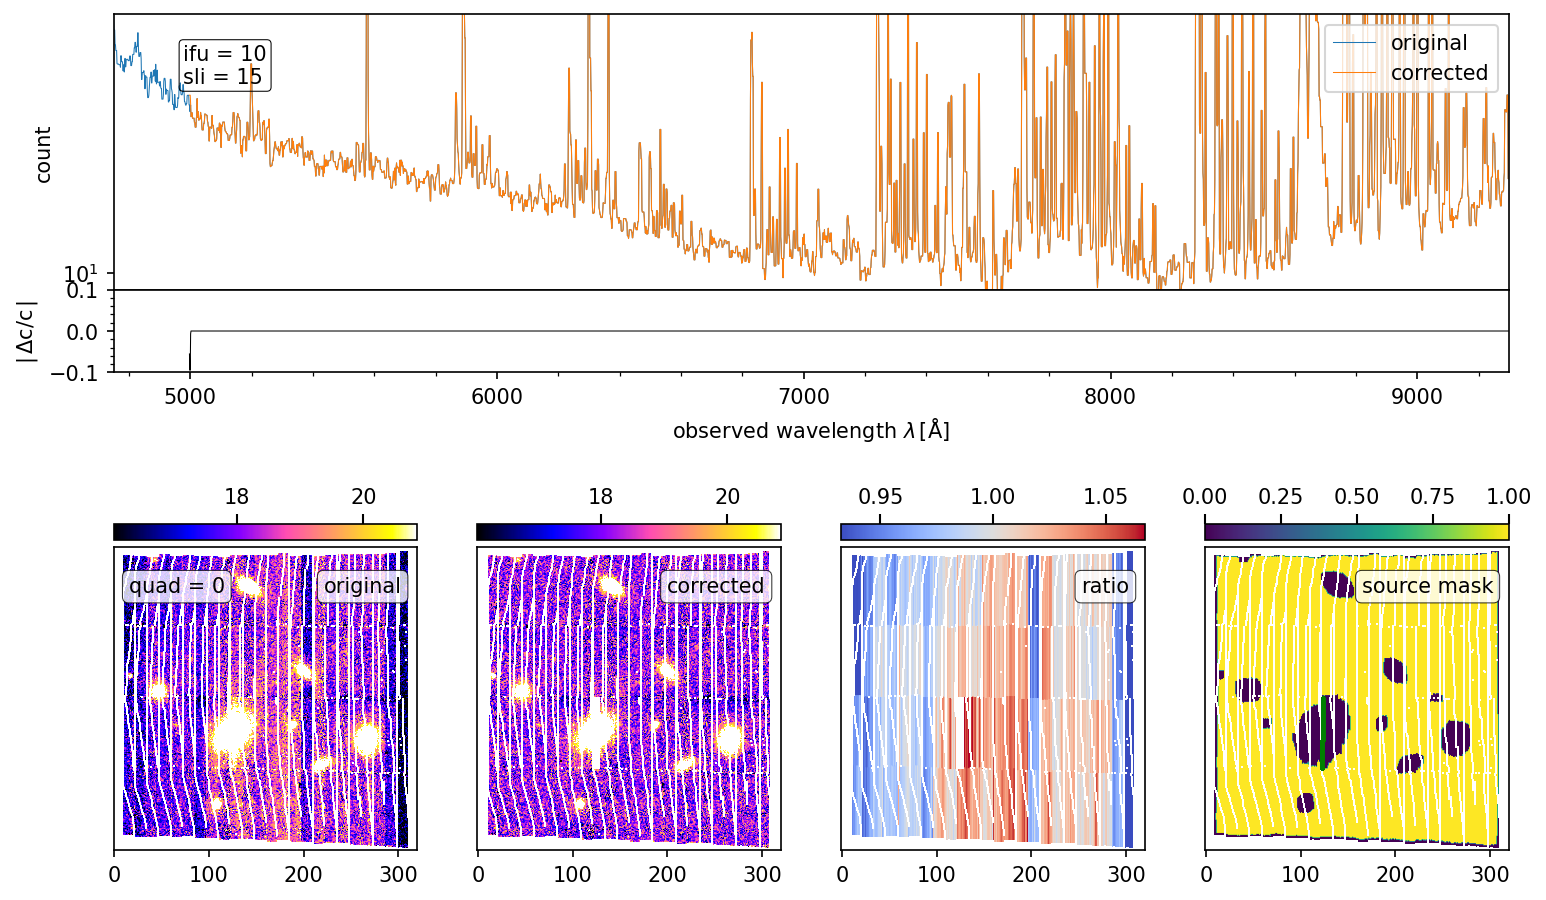

In [113]:
fig = p.plot_all(ifu=10,sli=15,quad=0)

In [100]:
#fig.savefig("PHL909_corr.jpg")